# Embedded ML Lab - Excercise 3 - Pruning

Now we will focus on structured pruning to save computation time. We will do this in three steps.  
* We will implement a function, similar to previous l1 pruning, to sets whole output channels to zero.  

* We will delete the zeroed-out channels and densify the network again to have a reduction in computation time.

* We will retrain the network to gain accuracy again.  



In [1]:
import torch
torch.rand(1).to('cuda') #initialize cuda context (might take a while)

from net import PrunedCifarNet
import torch
from typing import Dict, List
import numpy as np

import torchvision
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms
tf = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testloader = torch.utils.data.DataLoader(torchvision.datasets.CIFAR10('data/', train=False, download=True, transform=tf), shuffle=False, batch_size=32)
trainloader = torch.utils.data.DataLoader(torchvision.datasets.CIFAR10('data/', train=True, download=True, transform=tf), shuffle=True, batch_size=32)

Files already downloaded and verified
Files already downloaded and verified


In [2]:
import tqdm
import copy

from utils import net_acc, net_time, net_macs, plot

First, we focus on setting the output channels to zero.  
Your Task:
   * Implement the function `l1_structured_pruning`, that takes a `state_dict` and a `prune_ratio` as input. Calculate the l1 norm $||x||_1= \sum_{i=1}^N |x_i|$, of each output channel, and set the output channels with the lowest norm to zero to meet the prune_ratio.
       * Also, for each output channels that is zeroed-out, set the convolution's bias to zero
       * You can keep `conv1` and `conv2` unpruned.

In [3]:
import re

def l1_structured_pruning(state_dict: Dict, prune_ratio: float) -> Dict:
    state_dict = copy.deepcopy(state_dict)
    for key in state_dict:
        match = re.match(r"conv(\d)\.weight", key)
        if not match or match.group(1) == "1":
            continue
        idx = int(match.group(1))
        tensor = state_dict[key]
        
        l2s = []
        
        for i, subtens in enumerate(tensor):
            l2s.append(torch.sum(torch.abs(subtens)))
        
        perc = np.percentile(l2s, prune_ratio * 100)
        
        bias = state_dict[f"conv{idx}.bias"]
        
        for i, subtensor in enumerate(tensor):
            if l2s[i] < perc:
                tensor[i,:] = torch.zeros(tensor[i,:].shape)
                bias[i] = 0.0

    return state_dict

We now iteratively test the function for several pruning ratios. Right now, we get no gains in MACs (Multiply-accumulate operations), since the values are just set to zero.

100%|██████████| 15/15 [00:27<00:00,  1.86s/it]


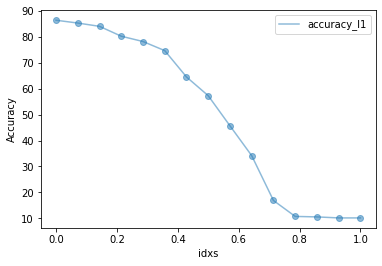

In [8]:
import tqdm
import copy

from utils import net_acc, net_time, net_macs, plot

ratios = np.linspace(0, 0.8, 15)

state_dict = torch.load('state_dict__cifarnet.pt')
accuracy_l1, idxs = [], []
for idx, ratio in tqdm.tqdm(enumerate(ratios), total=len(ratios)):
    state_dict = l1_structured_pruning(state_dict, ratio)
    accuracy_l1.append(net_acc(PrunedCifarNet, state_dict, testloader, batches=32, device='cuda'))
    idxs.append(idx)
plot([(idxs, accuracy_l1, 'accuracy_l1')], xlabel='idxs', save_path='accuracy_l1.png')

Next, we implement a function that removes the zeroed-out output channels to gain actual inference speed ups.

Your Tasks:
* For each `weight` tensor of conv2d layers, slice the tensor such that only the output channels with non-zero filters remain.
* If an output channel is removed, also remove its respective bias.
* For each consecutive conv layer, remove the input channels that are zeroed-out output channels of the previous conv layer   
* TIP: A tensor containing channels can be reshaped using a list of indices (e.g., `new_tensor = tensor[[1,2,3,5,6,7],:,:,:]` 
* For the last conv2d layer, you have to consider the flattened  output and slice the input of the fully connected layer. In the case of the `CifarNet` we currently use, the feature map before being flatted is $2\times 2$ with $256$ output channels, where `torch.flatten` arranges the channels starting with index $0$.

As a help, check the image: Each pruned output filter (gray/vertical) appears as a pruned input (red/horizontal) in the consecutive conv layer.  
<img src="src/prune.png" alt="drawing" width="700"/>

In [4]:
def densify_state_dict(state_dict: Dict) -> Dict:
    keep = None
    last_len = 0
    state_dict = copy.deepcopy(state_dict)    
    for key in state_dict:
        match = re.match(r"conv(\d)\.weight", key)
        if match and match.group(1) != "1":
            
            idx = int(match.group(1))
            tensor = state_dict[key]
            if keep is not None:
                tensor = tensor[:,keep,:,:]
            keep = []
            for i,subtens in enumerate(tensor): 
                if not torch.all(subtens == 0):
                    keep.append(i)
            last_len = len(tensor)
            state_dict[key] = tensor[keep,:,:,:]
            state_dict[f"conv{idx}.bias"] = state_dict[f"conv{idx}.bias"][keep]

    keep = [x * 4 for x in keep] + [x * 4 + 1 for x in keep] \
    + [x * 4 + 2 for x in keep] + [x * 4 + 3 for x in keep]
    keep.sort()
    state_dict["fc.weight"] = state_dict["fc.weight"][:,keep]
    return state_dict

If you have implemented the `densify_state_dict` function correctly, the plot (orange) should behave exactly the same (orange and blue should overlap).

In [9]:
state_dict = torch.load('state_dict__cifarnet.pt')
accuracy_dense = []
for idx, ratio in tqdm.tqdm(enumerate(ratios), total=len(ratios)):
    state_dict = l1_structured_pruning(state_dict, ratio)
    sd = densify_state_dict(state_dict)
    accuracy_dense.append(net_acc(PrunedCifarNet, sd, testloader, batches=32, device='cuda'))
plot([(idxs, accuracy_l1, 'accuracy_l1'), (idxs, accuracy_dense, 'accuracy_dense')], xlabel='idxs', save_path='accuracy_l1.png')

100%|██████████| 15/15 [00:28<00:00,  1.90s/it]


Now we implement the last missing pieces to apply iterative pruning. To save time, we only apply changes to the last linear layer, all other layers are frozen.

Your Tasks:
* Implement a training function that takes the `model_class` the `state_dict`, the `trainloader`, the number of batches, and device (cpu/cuda) as input and returns a state_dict as output.

In [5]:
def train(model_class: torch.nn.Module, state_dict: Dict,
          trainloader: torch.utils.data.DataLoader, batches: int=64, device: str='cpu'):

    # Learning rate
    lr = 0.01

    torch_device = torch.device(device)

    model = model_class()
    model.load_state_dict(state_dict)
    model.to(torch_device)

    model.train()
    
    # For all conv layers we disable the calculation of gradients in the backwards step
    for key, param in model.named_parameters():
        if any(x in key for x in ['1', '2', '3', '4', '5', '6']):
            param.requires_grad = False
    # The optimizer gets only the parameters that require gradient calculation
    optimizer = torch.optim.SGD(filter(lambda x: x.requires_grad, model.parameters()), lr=lr)
    
    # Loss function
    loss_f = torch.nn.CrossEntropyLoss()
    

    for idx, (inputs, targets) in enumerate(trainloader):
        optimizer.zero_grad()
        model = model.to(device)
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        loss = loss_f(outputs, targets)
        loss.backward()
        optimizer.step()
    return model.state_dict()

We now iteratively prune some percent and retrain the densified state dict. We therefor use an adaptable `PrunedCifarNet` that changes the layer definition based on the parameters dimensions of the state dict.

Furthermore, we plot two versions: One with fine-tuned parameters, one where no re-training is applied.

100%|██████████| 26/26 [23:32<00:00, 54.32s/it]


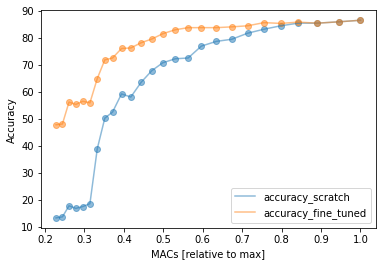

In [6]:
# define ratios
ratios = [0.0] + [0.025 for _ in range(25)]
state_dict = torch.load('state_dict__cifarnet.pt')
accuracy_from_scratch, accuracy_fine_tuned, macs = [], [], []

for ratio in tqdm.tqdm(ratios):
    
    # Setting Filters to zero
    state_dict = l1_structured_pruning(state_dict, ratio)
    
    # Densifying the state dict
    state_dict = densify_state_dict(copy.deepcopy(state_dict))
    
    # Accuracy calculation
    accuracy_from_scratch.append(net_acc(PrunedCifarNet, state_dict, testloader, batches=32, device='cuda'))

#We now do the same with training for comparions (this might take a while)
state_dict = torch.load('state_dict__cifarnet.pt')
for ratio in tqdm.tqdm(ratios):
    state_dict = l1_structured_pruning(state_dict, ratio)
    state_dict = densify_state_dict(copy.deepcopy(state_dict))
    
    #We fine tune the network by training with 150 batches
    state_dict = train(PrunedCifarNet, state_dict, trainloader, batches=32, device='cuda')
    accuracy_fine_tuned.append(net_acc(PrunedCifarNet, state_dict, testloader, batches=32, device='cuda'))
    macs.append(net_macs(PrunedCifarNet, state_dict))
    
    
plot([(macs, accuracy_from_scratch, 'accuracy_scratch'),
      (macs, accuracy_fine_tuned, 'accuracy_fine_tuned')],
      xlabel='MACs [relative to max]', save_path='accuracy_macs.png')